# Import needed libraries

In [1]:
# for dataset loading
import pandas as pd

# to visualize the molecules
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdmolops
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs

# for progress bars
from tqdm import tqdm, trange

# for figures
import matplotlib
from matplotlib import pyplot as plt

# for numerical operations
import numpy as np

# Load the compounds from csv

In [2]:
table=pd.read_csv("EGFR_compounds_lipinski.csv", sep=',')
table

,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...,...
4630,5562,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,5563,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,5564,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,5565,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


From this table, we need the SMILES strings and pIC50, so columns 4 & 5.

In [3]:
needed_info=table.iloc[:,[4,5]]
needed_info

,smiles,pIC50
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
...,...,...
4630,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027
4631,O=C(O)/C=C/c1ccc(O)cc1,2.522879
4632,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030
4633,N#CC(C#N)Cc1ccc(O)cc1,2.187087


# Analyze the pIC50 distribution
Is some data over represented? Will we need to unbias it?<br>
As the task is to distinduish compounds with pIC50>8, we can approach this as a binary classification problem: active vs inactive compounds.

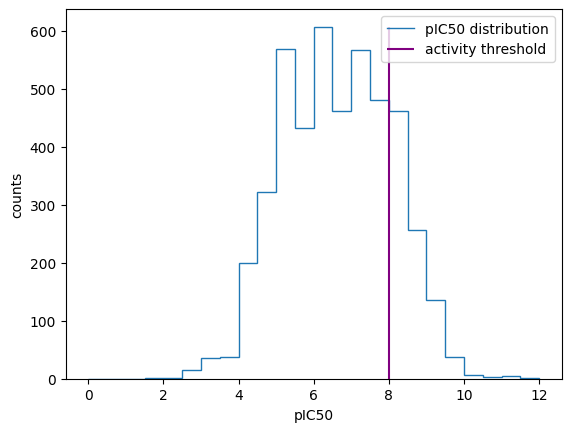

In [4]:
pIC50 = needed_info["pIC50"].values

# build a histogram
counts, bins = np.histogram(pIC50, range=(0,12), bins=12*2)
plt.stairs(counts, bins, label="pIC50 distribution")

# draw criterion for clasification as an active compound (pIC50=8)
plt.vlines(x = 8, ymin = 0, ymax = max(counts),
           colors = 'purple',
           label = 'activity threshold')

plt.xlabel("pIC50")
plt.ylabel("counts")
plt.legend()

plt.show()

In [5]:
actives = pIC50[pIC50>8]
print(f"{len(actives)*100./len(pIC50): .2f}% of compounds are active.")

 18.83% of compounds are active.


Yes, we have a lot fewer active compounds then inactives. Will need to try unbiasing.

# How do the compounds look?

In [6]:
from rdkit.Chem import PropertyMol

molecules = []
legends = []
canonical_smiles = [] # used to check for duplicates

for i in trange(needed_info.shape[0]):
    # build molecule from smiles string
    mol = Chem.MolFromSmiles(needed_info.iloc[i,0]) # smiles
    
    # check if the same molecule already exists and we have multiple measurements for it
    can_smi = Chem.MolToSmiles(mol)
    if(can_smi in canonical_smiles):
        # if this doesn't trigger, we are fine and don't need to handle this special case
        raise(Exception("Duplicate molecule:", needed_info.iloc[i,0], can_smi, "at entry", i))
    canonical_smiles.append(can_smi)
    
    # add hydrogens
    mol = rdmolops.AddHs(mol)
    
    # record properties
    mol.SetProp("ID", str(needed_info.iloc[i,0]))    # ID
    mol.SetProp("pIC50", str(needed_info.iloc[i,1])) # pIC50
        
    # save as a PropertyMol so properties can be pickled later
    mol = PropertyMol.PropertyMol(mol)
    molecules.append(mol)
    
    # add a label
    legends.append(f"pIC50={needed_info.iloc[i,1]: .2f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4635/4635 [00:01<00:00, 3402.84it/s]


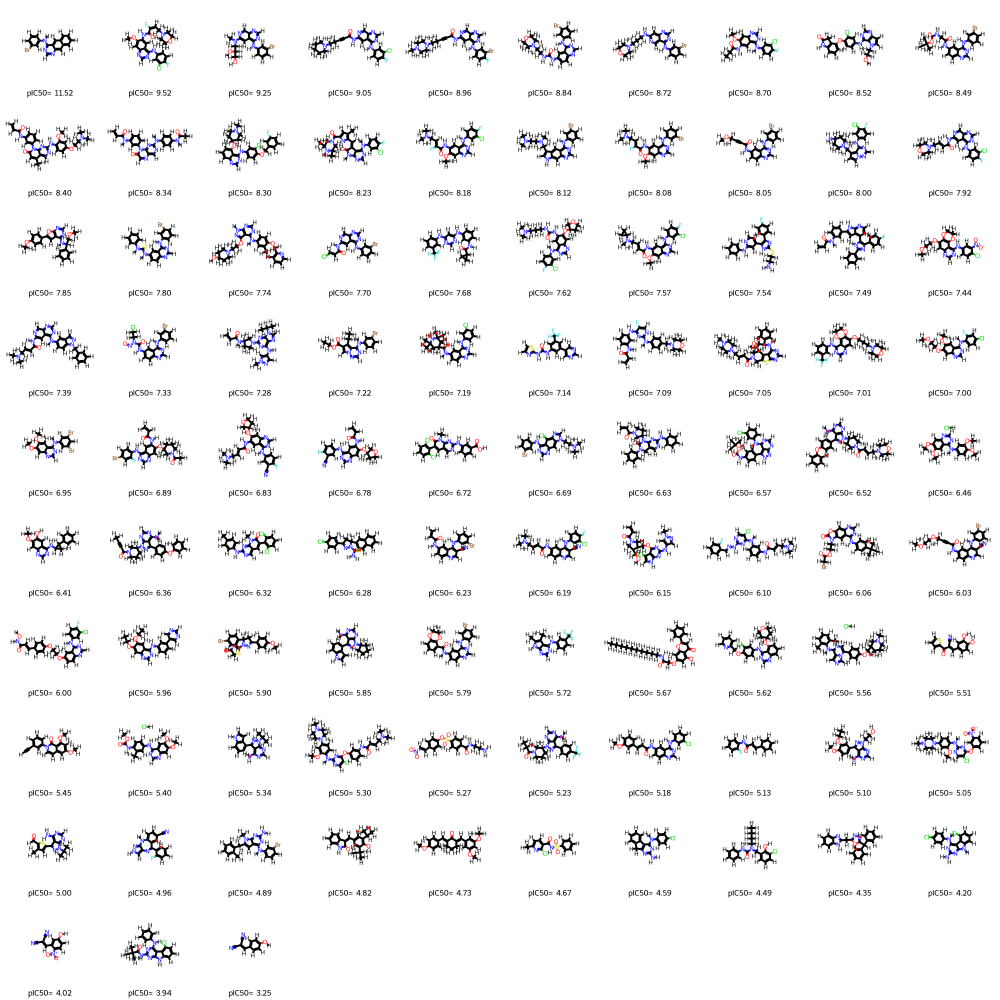

In [7]:
# draw the molecules
Draw.MolsToGridImage(molecules[::50],
                     legends=legends[::50],
                     molsPerRow=10,subImgSize=(100,100),
                     maxMols=200)

EGFR is a kinase. Inhibition of those usually happens in the ATP binding site, so predominance of compounds with two fused rings near to another ring is not surprising.

# Build 3D structures for the molecules and save them
This will be needed for 3D descriptors in RDKit. <br>
This is slow, but affordable for a dataset this small.
For large datasets, can just stop with the 2D representations above, but we will be limited 2D descriptors then.<br>
<p>
Unfortunately both UFF and MMFF have issues asigning charges to some in the molecules, so the structures can be unreasonable.<br>
To find out which molecules are affected, I need to capture stderr and check for new messages in it. Based on <a href="https://github.com/rdkit/rdkit/discussions/5435">this issue</a>.

In [8]:
from contextlib import redirect_stderr
from io import StringIO

problematic_molecules=[]
problem_descrs = []

with StringIO() as buf:
    for i in trange(needed_info.shape[0]):
        with redirect_stderr(buf): # capture stderr into buf
            AllChem.EmbedMolecule(molecules[i])        # Guess a 3D structure
            AllChem.MMFFOptimizeMolecule(molecules[i]) # Optimize it with MMFF
            
            err = buf.getvalue()
            if(err):
                print("Molecule", i, err)
                problematic_molecules.append(i)
                problem_descrs.append(err) # also keep track of the errors
                
                # purge buf so err is empty for next molecule
                buf.truncate(0)
                buf.seek(0)

 43%|██████████████████████████████████████████                                                        | 1990/4635 [01:46<02:42, 16.25it/s]

Molecule 1987 [18:18:18] UFFTYPER: Unrecognized charge state for atom: 8



 53%|███████████████████████████████████████████████████▋                                              | 2446/4635 [02:10<01:26, 25.29it/s]

Molecule 2441 [18:18:42] UFFTYPER: Unrecognized charge state for atom: 2



 53%|████████████████████████████████████████████████████                                              | 2463/4635 [02:11<01:36, 22.45it/s]

Molecule 2461 [18:18:43] UFFTYPER: Unrecognized charge state for atom: 33



 71%|█████████████████████████████████████████████████████████████████████▉                            | 3310/4635 [02:49<00:44, 29.56it/s]

Molecule 3307 [18:19:22] UFFTYPER: Unrecognized charge state for atom: 0
[18:19:22] UFFTYPER: Unrecognized atom type: Zn+2 (0)



 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 3959/4635 [03:15<00:21, 31.35it/s]

Molecule 3957 [18:19:48] UFFTYPER: Unrecognized charge state for atom: 1



 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 4154/4635 [03:22<00:17, 27.25it/s]

Molecule 4148 [18:19:54] UFFTYPER: Unrecognized charge state for atom: 22



 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 4506/4635 [03:34<00:03, 36.30it/s]

Molecule 4501 [18:20:06] UFFTYPER: Unrecognized charge state for atom: 1



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4635/4635 [03:37<00:00, 21.36it/s]

Molecule 4627 [18:20:09] UFFTYPER: Unrecognized charge state for atom: 1



## Draw the problem molecules in 3D and 2D

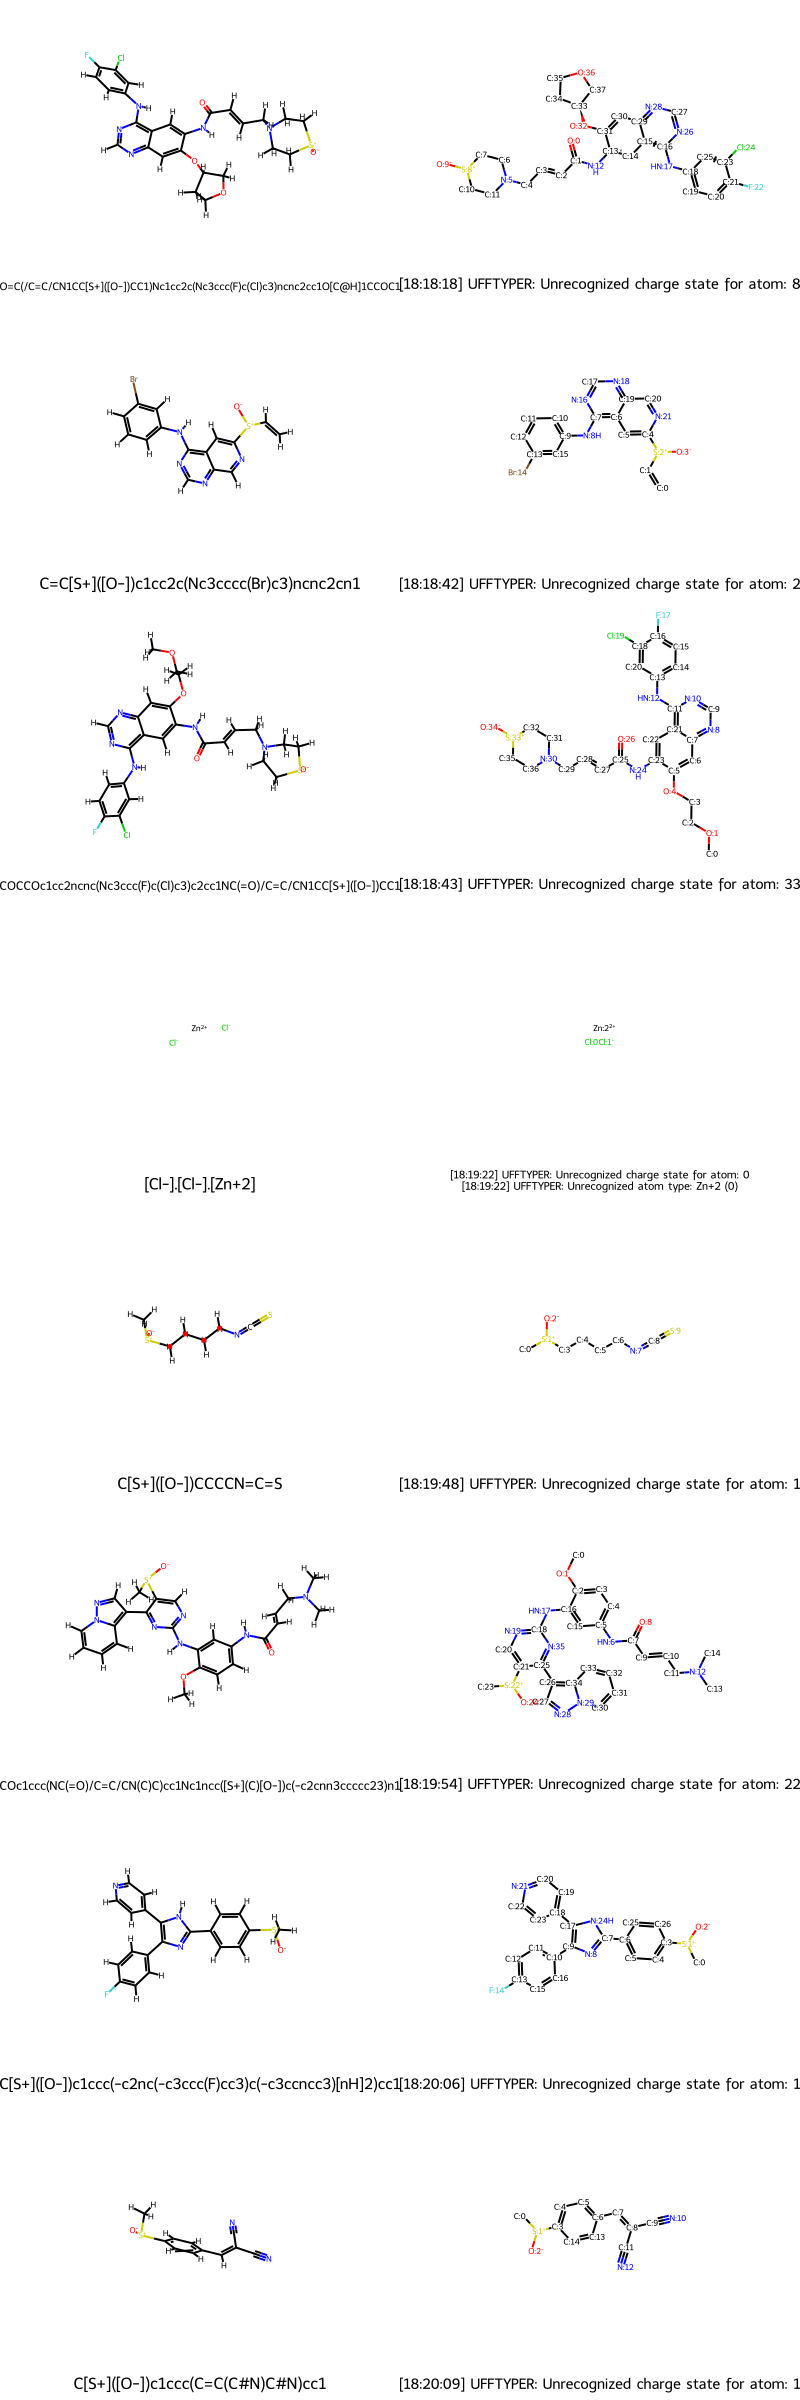

In [20]:
toDraw=[]
labels=[]
for e,i in enumerate(problematic_molecules):
    # make a 2D copy of the molecule for debugging
    mol2D = Chem.MolFromSmiles(needed_info.iloc[i,0]) # smiles
    # add atom labels to figure out which one produces the error
    for atom in mol2D.GetAtoms():
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))
    
    # show both 3D and 2D versions
    toDraw.extend([molecules[i], mol2D])
    # also show the error text and smiles
    labels.extend([needed_info.iloc[i,0], problem_descrs[e]]) 
    
del mol2D
    
# draw the selected molecules
Draw.MolsToGridImage(toDraw, legends=labels,
                     molsPerRow=2,subImgSize=(400,300),
                     maxMols=50)


Main culprits appear to be sufoxides. S is suposed to have a lone pair and an sp3d hybredization here. Instead it defaults to sp3 one, which is good enough. No need for any fixes.
<p>

The other issue is the ionic Zinc dichloride. Here all atoms are placed at origin. It can probably be avoided by removing the charge specifiction in the smiles and approximating ionic bonds by covalent ones.

[18:23:32] UFFTYPER: Unrecognized atom type: Zn1+2 (1)


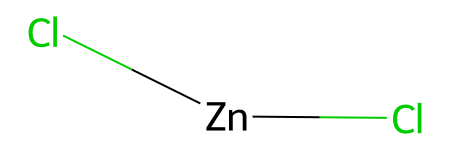

In [21]:
i=problematic_molecules[3] # Zinc dichloride

# new smiles:
smi = "[Cl][Zn][Cl]"
mol = Chem.MolFromSmiles(smi)

AllChem.EmbedMolecule(mol)        # Guess a 3D structure
AllChem.MMFFOptimizeMolecule(mol) # Optimize it with MMFF

# Draw the molecule
mol

RDKit still uses a fallback atom type for Zn, but at least the structure is reasonable now. <p> However, this will break the BCUT2D fingerprint for this molecule due to unusual hybridization. So let's copy the coordinates we got this way into the ionic form as an approximation.

new atom order is: ['Cl', 'Zn', 'Cl']
old atom order is: ['Cl', 'Cl', 'Zn']


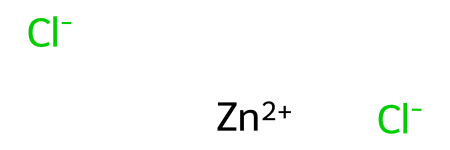

In [22]:
print("new atom order is:", [a.GetSymbol() for a in mol.GetAtoms()])
print("old atom order is:", [a.GetSymbol() for a in molecules[i].GetAtoms()])

# reorder atom coordinates with this index list
reorder = [0, 2, 1]
coords = mol.GetConformer().GetPositions()

# write them to ionic molecule already in the molecules list
for a in range(mol.GetNumAtoms()):
    molecules[i].GetConformer().SetAtomPosition(a, coords[reorder[a],:])

# Draw the molecule
molecules[i]

# Save the molecules
Now that we have all the 3D structures, we can pickle the molecules for later reuse in other steps of the project.

In [23]:
import pickle
with open("molecules_3D.pickle", 'wb') as f:
    pickle.dump(molecules, f)